In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as F
from pathlib import Path
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Reproducibility
SEED = 42
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

# Paths
project_root = Path("..").resolve()
manifest_path = project_root / "data" / "UT-EndoMRI" / "D2_Half_Split" / "d2_half_split_manifest.csv"

print(f"Manifest: {manifest_path}")

Using device: cuda
Manifest: C:\Users\lytten\programming\dlvr-project\data\UT-EndoMRI\D2_Half_Split\d2_half_split_manifest.csv


In [2]:
class OvaryDataset(Dataset):
    def __init__(self, manifest_path, split, image_size=256, augment=False):
        """
        Args:
            manifest_path: Path to the CSV.
            split: 'train', 'val', or 'test'.
            image_size: Target size for the network (e.g., 256x256).
            augment: Boolean, whether to apply rotation/shift.
        """
        self.df = pd.read_csv(manifest_path)
        
        # Filter by the 'split' column
        self.df = self.df[self.df['split'] == split].reset_index(drop=True)
        
        self.image_size = image_size
        self.augment = augment
        self.samples = [] # Will store (img_path, mask_path, slice_index)
        
        print(f"Initializing {split.upper()} dataset...")
        
        # Pre-scan to find all valid slices
        # This takes a few seconds but makes training much faster
        for idx, row in self.df.iterrows():
            # Handle relative paths if needed
            img_p = Path(row['t2fs_path'])
            msk_p = Path(row['ov_path'])
            if not img_p.exists():
                img_p = Path(manifest_path).parent / img_p.name
                msk_p = Path(manifest_path).parent / msk_p.name
                
            # Load full volume to check for positive slices
            # We assume the files are the "Half_Split" versions (already blacked out)
            msk_vol = nib.load(str(msk_p)).get_fdata()
            
            # Find z-indices where mask exists
            z_sums = np.sum(msk_vol, axis=(0, 1))
            valid_slices = np.where(z_sums > 0)[0]
            
            for z in valid_slices:
                self.samples.append({
                    'img_path': str(img_p),
                    'msk_path': str(msk_p),
                    'slice_idx': z,
                    'pid': row['pid']
                })
                
        print(f"  Found {len(self.samples)} positive slices from {len(self.df)} patients.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        info = self.samples[idx]
        
        # Load NIfTI
        img_vol = nib.load(info['img_path']).get_fdata()
        msk_vol = nib.load(info['msk_path']).get_fdata()
        
        # Extract specific slice
        z = info['slice_idx']
        img = img_vol[:, :, z]
        msk = msk_vol[:, :, z]
        
        # Normalize (0-1)
        # Robust min-max using percentiles to handle MRI outliers
        p1 = np.percentile(img, 1)
        p99 = np.percentile(img, 99)
        img = np.clip(img, p1, p99)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        
        # Binarize mask (ensure it's 0 or 1)
        msk = (msk > 0).astype(np.float32)
        
        # Convert to Tensor (C, H, W)
        # Nibabel loads as (W, H) usually, so we transpose to (H, W) for PyTorch
        img = torch.from_numpy(img.T).float().unsqueeze(0)
        msk = torch.from_numpy(msk.T).float().unsqueeze(0)
        
        # Resize
        img = F.resize(img, [self.image_size, self.image_size], interpolation=T.InterpolationMode.BILINEAR, antialias=True)
        msk = F.resize(msk, [self.image_size, self.image_size], interpolation=T.InterpolationMode.NEAREST, antialias=True)
        
        # Augmentation (Only for Training)
        if self.augment:
            # We must apply the SAME transform to both image and mask
            # Random Rotation (-25 to +25 degrees)
            angle = random.uniform(-25, 25)
            img = F.rotate(img, angle, interpolation=T.InterpolationMode.BILINEAR)
            msk = F.rotate(msk, angle, interpolation=T.InterpolationMode.NEAREST)
            
            # Random Translation (Shift) +/- 10%
            # 256 * 0.1 = 25 pixels (matches paper's ~25px)
            max_shift = int(self.image_size * 0.1)
            t_x = random.randint(-max_shift, max_shift)
            t_y = random.randint(-max_shift, max_shift)
            img = F.affine(img, angle=0, translate=(t_x, t_y), scale=1.0, shear=0, interpolation=T.InterpolationMode.BILINEAR)
            msk = F.affine(msk, angle=0, translate=(t_x, t_y), scale=1.0, shear=0, interpolation=T.InterpolationMode.NEAREST)
            
        return img, msk

Initializing TRAIN dataset...
  Found 101 positive slices from 21 patients.
Initializing VAL dataset...
  Found 38 positive slices from 8 patients.
Train size: 101
Val size: 38


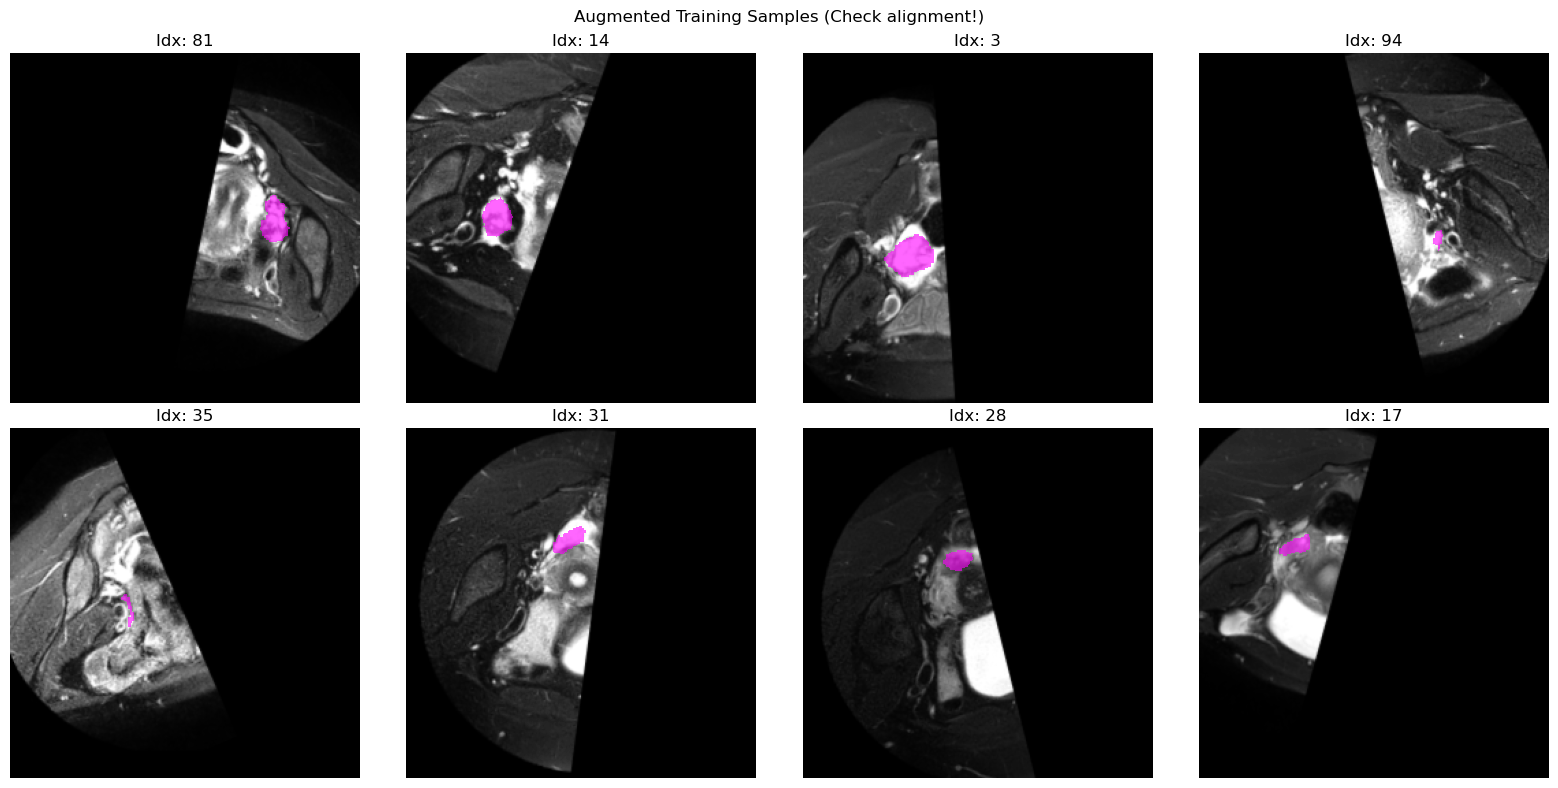

In [3]:
# Create datasets
train_ds = OvaryDataset(manifest_path, split='train', augment=True)
val_ds = OvaryDataset(manifest_path, split='val', augment=False)

print(f"Train size: {len(train_ds)}")
print(f"Val size: {len(val_ds)}")

# Sanity Check Visualization
# We pull a few samples from the training set to verify augmentation
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

indices = [random.randint(0, len(train_ds)-1) for _ in range(8)]

for ax, idx in zip(axes, indices):
    img, msk = train_ds[idx]
    
    # Convert back to numpy for plotting
    img_np = img.squeeze().numpy()
    msk_np = msk.squeeze().numpy()
    
    ax.imshow(img_np, cmap='gray', origin='lower')
    ax.imshow(np.ma.masked_where(msk_np == 0, msk_np), cmap='spring', alpha=0.6, origin='lower')
    ax.set_title(f"Idx: {idx}")
    ax.axis('off')

plt.suptitle("Augmented Training Samples (Check alignment!)")
plt.tight_layout()
plt.show()